In [50]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !apt install gdal-bin python-gdal python3-gdal 
    !apt install python3-rtree 
    !pip install descartes
    # git clone
    !git clone https://github.com/felixlapalma/monitoreo-espacios-verdes-diplo202X monitoreo-espacios-verdes-diplo202X
    %cd monitoreo-espacios-verdes-diplo202X
    !pip install -r requirements-colab.txt
    %cd notebooks
    import sys
    sys.path.append('..')
else:
    print('Running on Local')
    import sys
    sys.path.append('..')

Running on Local


In [107]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from pystac_client import Client
from eo_tilematcher import intersects, get_spacecraft_db
from earthpy import plot
import json
import rasterio as rio
#
from src.helper import calibrate_s2_scl
from src.helper import get_stac_items
from src.helper import _get_bands_data_from_planetary
from src.helper import _assemble_raster

# Satellite Images Download (Brief) Tutorial

## Planetary Computer

On [planetary computer](https://planetarycomputer.microsoft.com/catalog) images could be consulted by means of STAC catalogs, among them:

- Landsat
- Sentinel 1 and 2
- Alos
- etc

For this we have written some auxiliary scripts (check them at `/src` dir).

For _Planetary_ we need:

- a catalog (and a platform)
- a roi
- some dates
- some bandsdatesdates

In [3]:
from pystac_client import Client

### Catalog

In [4]:
# catalog instance
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

### ROI

In [17]:
# pick a roi
roi=gpd.read_file('../data/rois/san-roque-dam.geojson')

Just for reference we add Córdoba city

In [25]:
# check [ab-initio-mev-cba-1.ipynb] @ https://github.com/felixlapalma/monitoreo-espacios-verdes-diplo202X
gpd_roi = gpd.read_file("../data/rois/cordoba.geojson")
#
sentinel_match = intersects("sentinel2", gpd_roi)
sentinel2_tiles = get_spacecraft_db("sentinel2")
display(sentinel_match)

,geometry,match_polygon,match,TILE
0,"POLYGON ((-64.31465 -31.50421, -64.04686 -31.5...",POLYGON Z ((-64.31465148925781 -31.27796401330...,total,20JLL


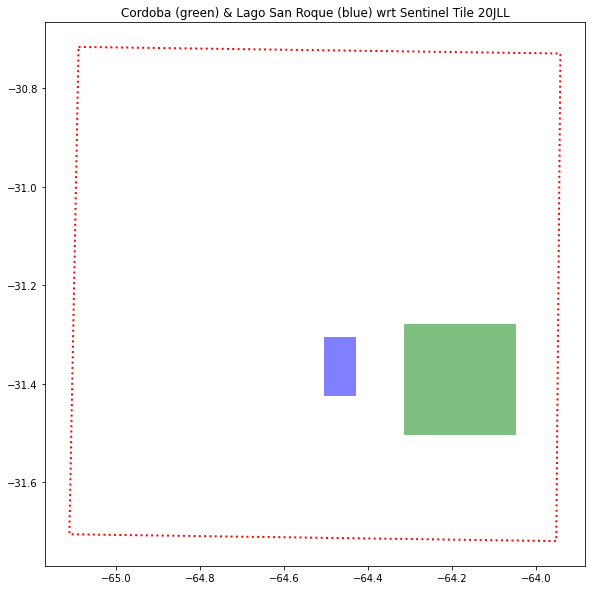

In [31]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sentinel_match.plot(ax=ax, edgecolor="None",facecolor="g", alpha=0.5)
tile = "20JLL"  ## Fill with TILE
sentinel2_tiles[sentinel2_tiles.TILE == tile].plot(
    ax=ax, facecolor="None", edgecolor="r", lw=2, ls=":"
)
roi.plot(ax=ax,facecolor='b',edgecolor="None",alpha=0.5)
ax.set_title(f"Cordoba (green) & Lago San Roque (blue) wrt Sentinel Tile {tile}");

In [39]:
# This way is arbitrary
query= {"catalog": catalog,
        "time_of_interest": "2022-02-01/2022-02-28",
        "cloud_cover": 40,
        "bbox": roi.total_bounds.tolist()
       }
# DISPLAY
query

In [41]:
stac_ret = get_stac_items(query)
stac_ret

[<Item id=S2A_MSIL2A_20220226T141741_R010_T20JLL_20220302T114201>,
 <Item id=S2B_MSIL2A_20220218T141039_R110_T20JLL_20220225T023510>,
 <Item id=S2A_MSIL2A_20220216T141741_R010_T20JLL_20220224T065210>,
 <Item id=S2A_MSIL2A_20220213T141051_R110_T20JLL_20220222T202245>,
 <Item id=S2B_MSIL2A_20220208T141039_R110_T20JLL_20220220T131349>,
 <Item id=S2A_MSIL2A_20220206T141741_R010_T20JLL_20220219T180427>,
 <Item id=S2A_MSIL2A_20220203T141051_R110_T20JLL_20220218T051643>,
 <Item id=S2B_MSIL2A_20220201T141729_R010_T20JLL_20220217T064238>]

In [48]:
# pick one
item_container=stac_ret[0]
item_container.properties

{'datetime': '2022-02-26T14:17:41.024000Z',
 'platform': 'Sentinel-2A',
 'proj:epsg': 32720,
 'instruments': ['msi'],
 's2:mgrs_tile': '20JLL',
 'constellation': 'Sentinel 2',
 's2:granule_id': 'S2A_OPER_MSI_L2A_TL_ESRI_20220302T114203_A034899_T20JLL_N04.00',
 'eo:cloud_cover': 25.077868,
 's2:datatake_id': 'GS2A_20220226T141741_034899_N04.00',
 's2:product_uri': 'S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_20220302T114201.SAFE',
 's2:datastrip_id': 'S2A_OPER_MSI_L2A_DS_ESRI_20220302T114203_S20220226T142306_N04.00',
 's2:product_type': 'S2MSI2A',
 'sat:orbit_state': 'descending',
 's2:datatake_type': 'INS-NOBS',
 's2:generation_time': '2022-03-02T11:42:01.654242Z',
 'sat:relative_orbit': 10,
 's2:water_percentage': 0.217634,
 's2:mean_solar_zenith': 35.8412637524774,
 's2:mean_solar_azimuth': 57.2344541957432,
 's2:processing_baseline': '04.00',
 's2:snow_ice_percentage': 0.0,
 's2:vegetation_percentage': 59.89539,
 's2:thin_cirrus_percentage': 0.006436,
 's2:cloud_shadow_percentage':

In [ ]:
item_container

### Bands

In [47]:
BANDS=["B02", "B03", "B04", "B08", "B8A", "SCL"]

### Now Query the Catalog

In [51]:
# b and p stands for bands and profiles
# they are dicts that return each band as a numpy array and profiles as a dict
b, p = _get_bands_data_from_planetary(
    item_container,
    BANDS,
    query['bbox'],
)

In [75]:
print(f"Bands: {b.keys()} \nProfiles: {p.keys()}\nB02\n - shape: {b['B02'].shape}\n - profile: {p['B02']}")


Bands: dict_keys(['B02', 'B03', 'B04', 'B08', 'B8A', 'SCL']) 
Profiles: dict_keys(['B02', 'B03', 'B04', 'B08', 'B8A', 'SCL'])
B02
 - shape: (1, 1333, 721)
 - profile: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 721, 'height': 1333, 'count': 1, 'crs': CRS.from_epsg(32720), 'transform': Affine(10.0, 0.0, 356910.0,
       0.0, -10.0, 6535760.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


In [134]:
# Now assemble a raster for bands
# Notice that Bands and SCL can not go in the same raster due to differents dtypes 
# We could cast both to a single type, but we will not explore here that alternative


Text(0.5, 1.0, 'SCL - Only CLOUD_HIGH_PROBABILITY ')

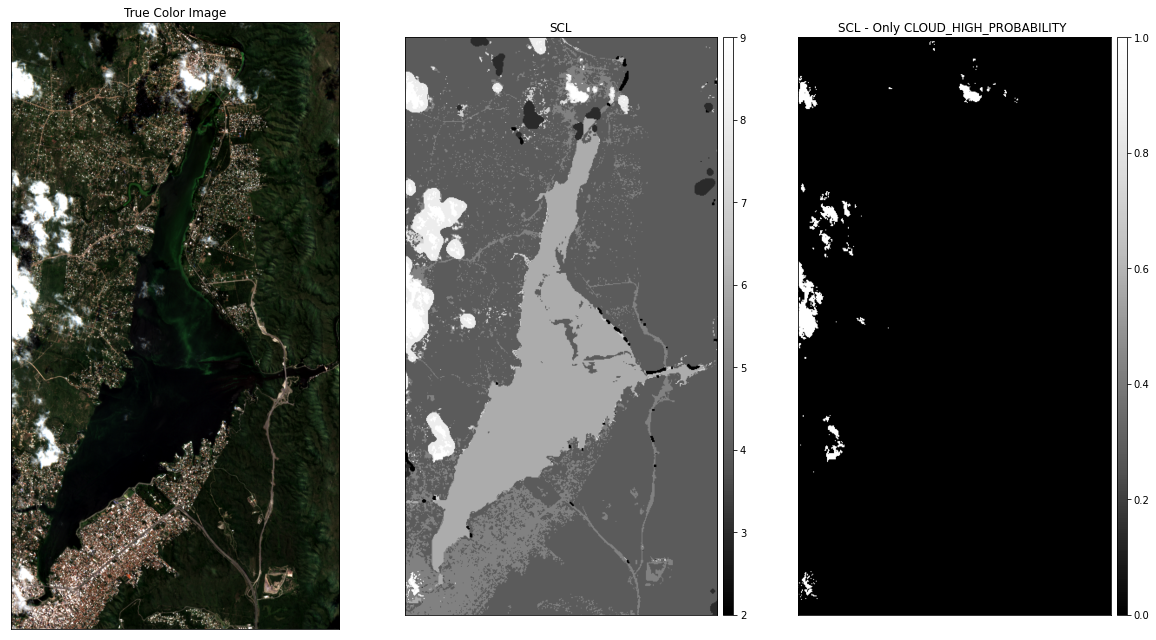

In [147]:
f, ax = plt.subplots(1, 3, figsize=(20, 20))
raster_cog = _assemble_raster(b, p, ["B02", "B03", "B04", "B08", "B8A"])
plot.plot_rgb(raster_cog.read(), rgb=(2, 1, 0),ax=ax[0],stretch=True)
ax[0].set_title("True Color Image")

raster_cloud_cog = _assemble_raster(b, p, ["SCL"])
plot.plot_bands(raster_cloud_cog.read(),ax=ax[1])
ax[1].set_title("SCL")

# leave only 9 	CLOUD_HIGH_PROBABILITY
cloud_mask_cog = calibrate_s2_scl(raster_cloud_cog, [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11])
plot.plot_bands(cloud_mask_cog.read(),ax=ax[2])
ax[2].set_title("SCL - Only CLOUD_HIGH_PROBABILITY ")

#### SCL stands for Scene Classification Layer

REF: https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm

- 0 	NO_DATA
- 1 	SATURATED_OR_DEFECTIVE
- 2 	DARK_AREA_PIXELS
- 3 	CLOUD_SHADOWS
- 4 	VEGETATION
- 5 	NOT_VEGETATED
- 6 	WATER
- 7 	UNCLASSIFIED
- 8 	CLOUD_MEDIUM_PROBABILITY
- 9 	CLOUD_HIGH_PROBABILITY
- 10 	THIN_CIRRUS
- 11 	SNOW

## Full Image Approach (Sentinel hub Case)

In [78]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

/data/sat-img-download-tutorial/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Credentials

Get some credentials for sentinelsat usage (follow the instruccions @ https://sentinelsat.readthedocs.io/en/stable/)

__Optional__: Make a json file @ data/credentials/sentinelhub.json with keys user,pass otherwise fill the creds and set to `False` the corresponding flag `creds_file`.

In [83]:
creds_file=True
if creds_file:
    with open('../data/rois/credentials/sentinelhub.json','r') as f:
        config=json.load(f)
    user_=config['user']
    pass_=config['pass']
else:
    user_='XXXXX' ## fill with your own creds
    pass_='XXXXX' ## fill

In [84]:
api = SentinelAPI(user_, pass_)

In [85]:
# search by polygon, time, and SciHub query keywords
footprint = geojson_to_wkt(read_geojson('../data/rois/san-roque-dam.geojson'))
#
products = api.query(footprint,
                     date=('20220201', '20220228'),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 40))

In [89]:
# convert to Pandas DataFra<me
products_s2 = api.to_dataframe(products)
#
dow=products_s2[products_s2.processinglevel =='Level-2A']
dow

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,datatakesensingstart,sensoroperationalmode,tileid,hv_order_tileid
954ce31d-21e0-4357-9c08-1cc062d4aec2,S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2022-02-26T14:17:41.024Z, Instrument: MS...",false,2022-02-26 19:12:32,2022-02-26 14:17:41.024,2022-02-26 14:17:41.024,2022-02-26 22:36:40.859,...,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20220226T191232_S2022...,S2A_OPER_MSI_L2A_TL_VGS2_20220226T191232_A0348...,S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_2...,954ce31d-21e0-4357-9c08-1cc062d4aec2,NaT,NaN,NaN,NaN
3ffbe558-819c-4753-ab67-cbd62a9ac1cc,S2B_MSIL2A_20220218T141039_N0400_R110_T20JLL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2022-02-18T14:10:39.024Z, Instrument: MS...",false,2022-02-18 19:29:03,2022-02-18 14:10:39.024,2022-02-18 14:10:39.024,2022-02-19 00:27:29.661,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_VGS2_20220218T192903_S2022...,S2B_OPER_MSI_L2A_TL_VGS2_20220218T192903_A0258...,S2B_MSIL2A_20220218T141039_N0400_R110_T20JLL_2...,3ffbe558-819c-4753-ab67-cbd62a9ac1cc,NaT,NaN,NaN,NaN
56390f2c-fd35-43ef-b9bc-55ae319a793c,S2A_MSIL2A_20220216T141741_N0400_R010_T20JLL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2022-02-16T14:17:41.024Z, Instrument: MS...",false,2022-02-16 21:30:13,2022-02-16 14:17:41.024,2022-02-16 14:17:41.024,2022-02-17 01:38:02.645,...,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20220216T213013_S2022...,S2A_OPER_MSI_L2A_TL_VGS2_20220216T213013_A0347...,S2A_MSIL2A_20220216T141741_N0400_R010_T20JLL_2...,56390f2c-fd35-43ef-b9bc-55ae319a793c,NaT,NaN,NaN,NaN
03889a82-ee28-4ec5-a778-d56abc819d78,S2A_MSIL2A_20220213T141051_N0400_R110_T20JLL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2022-02-13T14:10:51.024Z, Instrument: MS...",false,2022-02-13 19:06:53,2022-02-13 14:10:51.024,2022-02-13 14:10:51.024,2022-02-13 23:38:53.729,...,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20220213T190653_S2022...,S2A_OPER_MSI_L2A_TL_VGS2_20220213T190653_A0347...,S2A_MSIL2A_20220213T141051_N0400_R110_T20JLL_2...,03889a82-ee28-4ec5-a778-d56abc819d78,NaT,NaN,NaN,NaN
5065ed9c-4128-4163-a233-c086540cfb71,S2B_MSIL2A_20220208T141039_N0400_R110_T20JLL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2022-02-08T14:10:39.024Z, Instrument: MS...",false,2022-02-08 18:45:43,2022-02-08 14:10:39.024,2022-02-08 14:10:39.024,2022-02-08 23:06:20.210,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_VGS2_20220208T184543_S2022...,S2B_OPER_MSI_L2A_TL_VGS2_20220208T184543_A0257...,S2B_MSIL2A_20220208T141039_N0400_R110_T20JLL_2...,5065ed9c-4128-4163-a233-c086540cfb71,NaT,NaN,NaN,NaN
ae008c83-19c6-40a8-9177-9d4fa6106b53,S2A_MSIL2A_20220206T141741_N0400_R010_T20JLL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2022-02-06T14:17:41.024Z, Instrument: MS...",false,2022-02-06 20:54:26,2022-02-06 14:17:41.024,2022-02-06 14:17:41.024,2022-02-06 23:54:35.804,...,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20220206T205426_S2022...,S2A_OPER_MSI_L2A_TL_VGS2_20220206T205426_A0346...,S2A_MSIL2A_20220206T141741_N0400_R010_T20JLL_2...,ae008c83-19c6-40a8-9177-9d4fa6106b53,NaT,NaN,NaN,NaN
026bac3c-2708-463c-84ce-2f2eff41c0

Just for comparison, we will use the same image as before `S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_20220302T114201.SAFE`

In [91]:
os.makedirs('../TMP-images-raw',exist_ok=True)

In [92]:
api.download_all(dow.head(1).index,directory_path='../TMP-images-raw/')


MD5 checksumming:   0%|                                                        | 0.00/1.18G [00:00<?, ?B/s]
MD5 checksumming:   4%|█▉                                              | 47.3M/1.18G [00:00<00:02, 473MB/s]
MD5 checksumming:   8%|███▊                                            | 94.6M/1.18G [00:00<00:02, 463MB/s]
MD5 checksumming:  12%|█████▉                                           | 143M/1.18G [00:00<00:02, 474MB/s]
MD5 checksumming:  16%|███████▉                                         | 191M/1.18G [00:00<00:02, 452MB/s]
MD5 checksumming:  20%|█████████▊                                       | 236M/1.18G [00:00<00:02, 434MB/s]
MD5 checksumming:  24%|███████████▋                                     | 280M/1.18G [00:00<00:02, 436MB/s]
MD5 checksumming:  28%|█████████████▌                                   | 327M/1.18G [00:00<00:01, 446MB/s]
MD5 checksumming:  32%|███████████████▍                                 | 371M/1.18G [00:00<00:01, 446MB/s]
MD5 checksumming:  36%|████

ResultTuple(downloaded={'954ce31d-21e0-4357-9c08-1cc062d4aec2': {'id': '954ce31d-21e0-4357-9c08-1cc062d4aec2', 'title': 'S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_20220226T191232', 'size': 1176441950, 'md5': '0c963cd5ecc842fe531606eaf0063961', 'date': datetime.datetime(2022, 2, 26, 14, 17, 41, 24000), 'footprint': 'POLYGON((-63.946747 -31.188218226035687,-63.950043 -31.200921834385685,-63.988342 -31.34831483953536,-64.02664 -31.495828608364253,-64.06491 -31.643443467692485,-64.08429 -31.718099859282713,-65.11047 -31.70577277981865,-65.08859 -30.715722607161137,-63.94217 -30.72910890902974,-63.946747 -31.188218226035687))', 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('954ce31d-21e0-4357-9c08-1cc062d4aec2')/$value", 'Online': True, 'Creation Date': datetime.datetime(2022, 2, 26, 22, 37, 2, 701000), 'Ingestion Date': datetime.datetime(2022, 2, 26, 22, 36, 40, 859000), 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('954ce31d-21e0-4357-9c08-1cc0

In [94]:
# Now Extract the Package
from zipfile import ZipFile
with ZipFile('../TMP-images-raw/S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_20220226T191232.zip', 'r') as zipObj:
    zipObj.extractall(path='../TMP-images-raw/')

We have the full Image, let us show the whole picture and then we crop to the roi

In [95]:
from eo_forge.io.SentinelLoaders import Sentinel2Loader

In [123]:
# Init Loader and query bands
# Notice that we do not include SCL in this case. It is auto added by the 
SENTINEL2_BANDS = ["B02", "B03", "B04", "B08", "B8A"]
IMAGES_RAW='../TMP-images-raw/'
lp = Sentinel2Loader(IMAGES_RAW, bands=SENTINEL2_BANDS, resolution=10,level='l2a')

2022/06/23 10:00:49 - INFO - Running on Sentinel 2 - l2a data


In [124]:
# Set product ID
product_id='S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_20220226T191232.SAFE'

In [125]:
PROD_INT_DIR='../TMP-images-proc'
os.makedirs(PROD_INT_DIR,exist_ok=True)

__NOTE__: Notice the `calibrate` flag if set to `True` it calibrates the bands with the coefficients from the corresponding metadata, and leaving the bands with a dtype float which turns the file quiet big, from ~ 300Mb  to almost 2Gb for the bands picked. In this case the bands maintain the dtype as `uint`.

In [170]:
res_bbox = lp.execute(
    product_id,
    bbox=None,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=False,
    write_file="_complete",
    calibrate=False,
)

2022/06/23 10:42:02 - INFO - Processing on ../TMP-images-raw/S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_20220226T191232.SAFE dir
2022/06/23 10:42:02 - INFO - Using clipping flag: False
2022/06/23 10:42:02 - INFO - PROCESSING band: B02
2022/06/23 10:42:02 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/06/23 10:42:02 - INFO - no bbox - full match: True - area: 1
2022/06/23 10:42:15 - INFO - calibrating band
2022/06/23 10:42:19 - INFO - reprojecting band
2022/06/23 10:42:21 - INFO - PROCESSING band: B03
2022/06/23 10:42:21 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/06/23 10:42:21 - INFO - no bbox - full match: True - area: 1
2022/06/23 10:42:27 - INFO - calibrating band
2022/06/23 10:42:28 - INFO - reprojecting band
2022/06/23 10:42:29 - INFO - PROCESSING band: B04
2022/06/23 10:42:29 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/06/23 10:42:29 - INFO - no bbox - full match: True - area: 1
2022/06/23 10:42:34 - INFO - calibratin

In [114]:
res_bbox

{'raster': None,
 'raster_cloud': None,
 'match': 'TOTAL',
 'raster_path': '../TMP-images-proc/S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_20220226T191232_complete.TIF',
 'raster_cloud_path': '../TMP-images-proc/S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_20220226T191232_CLOUDS_complete.TIF'}

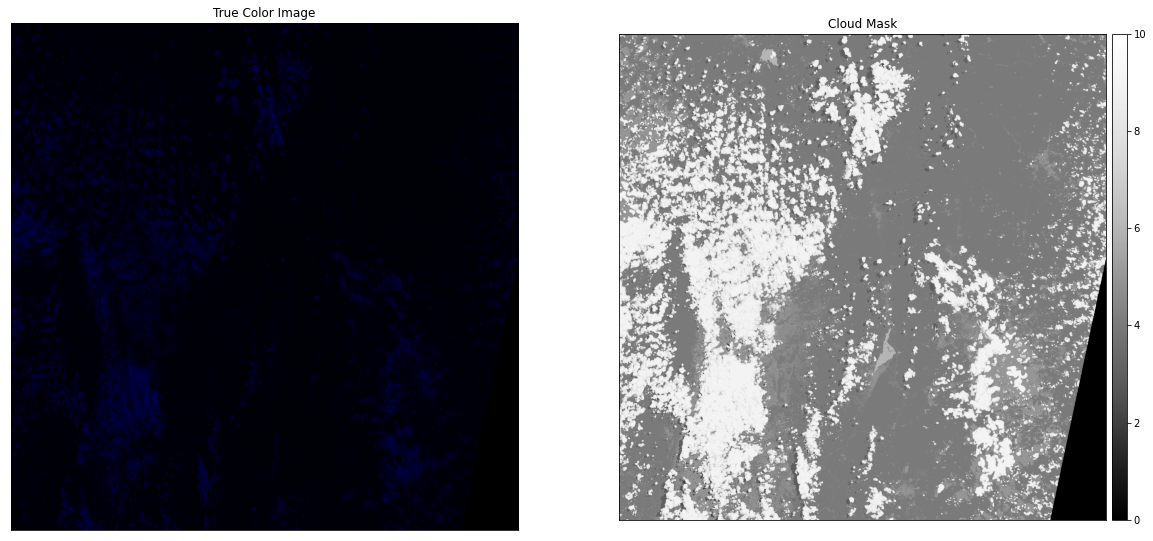

In [127]:
f, ax = plt.subplots(1, 2, figsize=(20, 20))
raster = rio.open(res_bbox["raster_path"])
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[0], stretch=False)
ax[0].set_title("True Color Image")
raster.close()

# for the clouds we use the source
raster = rio.open(lp.metadata_['band_files']['SCL'])
plot.plot_bands(raster.read(), ax=ax[1])
ax[1].set_title("Cloud Mask")
raster.close()

###  Now on BBOX

In [171]:
res_bbox_on = lp.execute(
    product_id,
    bbox=roi,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    calibrate=True,
    hard_bbox=True,
)

2022/06/23 10:45:52 - INFO - Processing on ../TMP-images-raw/S2A_MSIL2A_20220226T141741_N0400_R010_T20JLL_20220226T191232.SAFE dir
2022/06/23 10:45:52 - INFO - Using clipping flag: True
2022/06/23 10:45:52 - INFO - PROCESSING band: B02
2022/06/23 10:45:52 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/06/23 10:45:52 - INFO - checking  ROI
2022/06/23 10:45:52 - INFO - checking roi match - full match: True - area: 1
2022/06/23 10:45:52 - INFO - clipping with Tight BBox
2022/06/23 10:45:52 - INFO - calibrating band
2022/06/23 10:45:52 - INFO - reprojecting band
2022/06/23 10:45:52 - INFO - PROCESSING band: B03
2022/06/23 10:45:52 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/06/23 10:45:52 - INFO - checking  ROI
2022/06/23 10:45:52 - INFO - checking roi match - full match: True - area: 1
2022/06/23 10:45:52 - INFO - clipping with Tight BBox
2022/06/23 10:45:53 - INFO - calibrating band
2022/06/23 10:45:53 - INFO - reprojecting band
2022/06/23 10:45:53 

In [162]:
res_bbox_on

{'raster': <open DatasetReader name='/vsimem/2da5dd86-3ef2-4c5f-a472-cec8a892f4b1/2da5dd86-3ef2-4c5f-a472-cec8a892f4b1.tif' mode='r'>,
 'raster_cloud': <open DatasetReader name='/vsimem/30394fbf-5ba1-490a-a563-18fc0f269bd4/30394fbf-5ba1-490a-a563-18fc0f269bd4.tif' mode='r'>,
 'match': 'TOTAL',
 'raster_path': None,
 'raster_cloud_path': None}

Text(0.5, 1.0, 'Cloud Mask')

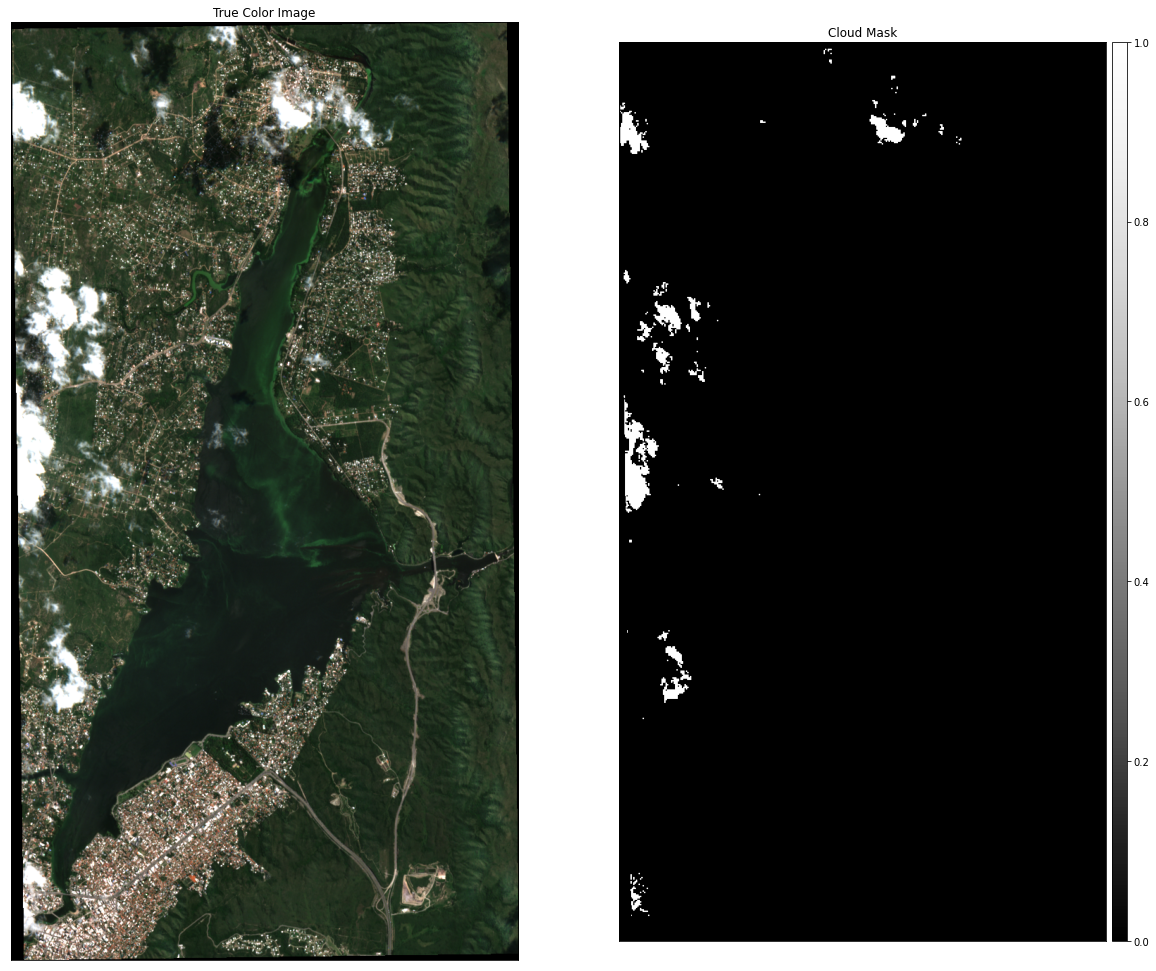

In [172]:
f, ax = plt.subplots(1, 2, figsize=(20, 20))
raster = res_bbox_on["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[0],stretch=True)
ax[0].set_title("True Color Image")

raster = res_bbox_on["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[1])
ax[1].set_title("Cloud Mask")